# 0. Dependencies

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%%script false --no-raise-error
! unzip /content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/Paintings.zip -d /content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/

In [5]:
%%script false --no-raise-error
! unzip /content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/task2/BUS_images.zip -d /content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/task2

In [6]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 56.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [7]:
import sys
from pathlib import Path
import datetime
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import cv2
import natsort
import csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers.legacy import SGD, Adam
#from tensorflow.python.keras.optimizers import Adam
from matplotlib import pyplot as plt
from art.attacks.evasion import BoundaryAttack
from art.estimators.classification import KerasClassifier
from art.utils import to_categorical
from art.attacks.evasion import ProjectedGradientDescent
import imageio
from tensorflow.keras.applications import vgg16
from art.estimators.classification import KerasClassifier,TensorFlowV2Classifier
from art.estimators import KerasEstimator
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent,NewtonFool,DeepFool

# This line is important, without it the attacks in the ART toolbox won't work
# And it needs to be run before training the models
tf.compat.v1.disable_eager_execution()

# Print the version of tensorflow and keras
print("TensorFlow version:{}".format(tf.__version__))
print("Keras version:{}".format(keras.__version__))

TensorFlow version:2.12.0
Keras version:2.12.0


In [106]:
from art.attacks.poisoning.perturbations import add_single_bd, insert_image
from art.attacks.poisoning import PoisoningAttackBackdoor

In [8]:
task1_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/task1"

In [9]:
task2_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/task2"

# Part 1: Adversarial Training Defense

## 1.1 Load the dataset and train the model

In [ ]:
# Function to load the images and the labels from the dataset
def load_images(directory):

    imgs_list = []

    # Read the images as numpy arrays
    imagesList = listdir(directory)
    for i in range(len(imagesList)):
        tmp_img = cv2.imread(os.path.join(directory, imagesList[i]))
        # Resize all images to 224 x 224 pixels
        resized_img = cv2.resize(tmp_img, (224, 224)) 
        img_arr = np.array(resized_img)
        #imgs_list.append(img_arr.astype(float))
        imgs_list.append(img_arr.astype(int))
    
    # Convert the lists to numpy arrays
    imgs = np.asarray(imgs_list)

    return imgs

def load_labels(CSV_path):
    label_list = []
    label_dict = {}
    index = -1
    with open(CSV_path, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if row[0] not in label_dict.values():
                index += 1
                label_dict[index] = row[0]
                
            label_list.append(index)

    return label_list, label_dict

In [ ]:
task1_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/task1"

In [ ]:
#%%script false --no-raise-error
# save images
img_path = os.path.join(task1_path, "Paintings")
all_images = load_images(img_path)
img_export_path = os.path.join(task1_path, "all_images")

In [ ]:
#%%script false --no-raise-error
# save labels
csv_path = os.path.join(task1_path, "labels_paintings.csv")
all_labels, label_dict = load_labels(csv_path)
label_export_path = os.path.join(task1_path, "all_labels")

In [ ]:
all_images, all_labels = shuffle(all_images, all_labels, random_state=3600)
np.save(img_export_path, all_images)
np.save(label_export_path, all_labels)

In [ ]:
%%script false --no-raise-error
print(label_dict)

{0: 'Cezanne', 1: 'Degas', 2: 'Gauguin', 3: 'Hassam', 4: 'Matisse', 5: 'Monet', 6: 'Pissarro', 7: 'Renoir', 8: 'Sargent', 9: 'VanGogh'}


In [ ]:
# load imgs and labels
all_images = np.load(os.path.join(task1_path, "all_images.npy"))
all_labels = np.load(os.path.join(task1_path, "all_labels.npy"))

In [ ]:
# Split into train, test, and validation sets
trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=160)
train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, trainval_labels, test_size=0.2, random_state=22966)
del all_images, trainval_images

In [ ]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images 
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)


Images train shape: (2552, 224, 224, 3) - Labels train shape: (2552,)
Images validation shape: (638, 224, 224, 3) - Labels validation shape: (638,)
Images test shape: (798, 224, 224, 3) - Labels test shape: (798,)

Max pixel value 255
Min pixel value 0
Average pixel value 115.80471637693209
Data type int64


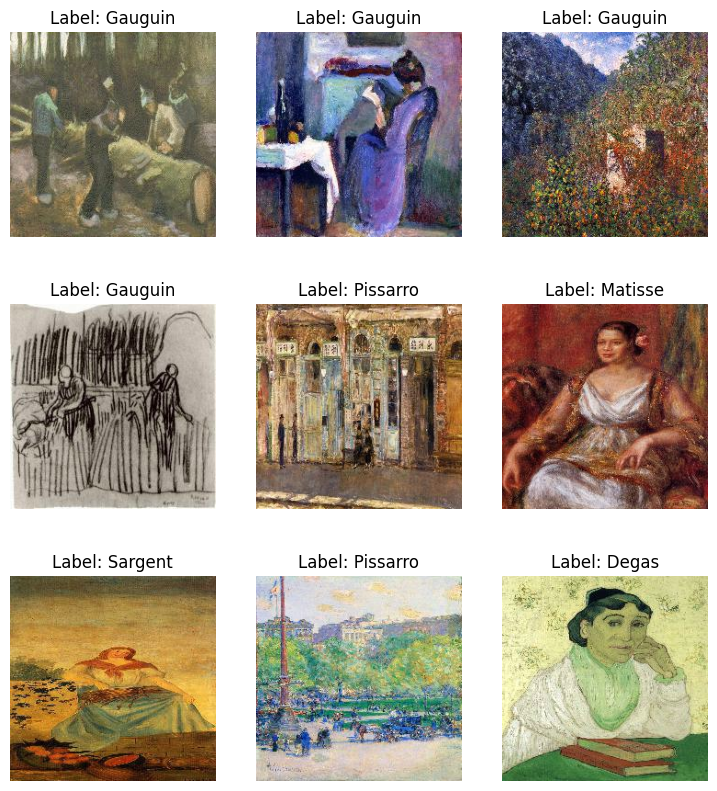

In [ ]:
# A list with the names of the image classes
               
# Plot a few images to check if the labels make sense
labels_dict = {0: 'Cezanne', 1: 'Degas', 2: 'Gauguin', 3: 'Hassam', 4: 'Matisse', 5: 'Monet', 6: 'Pissarro', 7: 'Renoir', 8: 'Sargent', 9: 'VanGogh'}
plt.figure(figsize=(9, 10))
for n in range(9):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(train_images[i[0]].astype(int))
    plt.title('Label: ' + str(labels_dict[train_labels[i[0]]]))
    plt.axis('off')

In [ ]:
train_labels_onehot = keras.utils.to_categorical(train_labels, 10)
test_labels_onehot = keras.utils.to_categorical(test_labels, 10)
val_labels_onehot = keras.utils.to_categorical(val_labels, 10)

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))
#base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))

# Add a global spatial average pooling layer
x = base_model.output

#'''
base_model.trainable = False

# un-freeze the BatchNorm layers
for layer in base_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True
#'''

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.2)(x)
predictions = Dense(10, activation='softmax')(x)

trans_resnet = Model(inputs=base_model.input, outputs=predictions)
# for layer in base_model.layers[:-1]:
#     layer.trainable = False

# trans_resnet.summary()


# The model we will train

adam_fine = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #20x smaller than standard

trans_resnet.compile(#optimizer=Adam(learning_rate=1e-4),
                     #optimizer=SGD(learning_rate=0.0001),
                     optimizer=adam_fine,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

PATIENCE = 10
callbacks = [EarlyStopping(monitor='val_loss',
                   patience = PATIENCE,
                   restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1)
             #LRFinder(min_lr=1e-6, max_lr=1e-3)
            ]

In [ ]:
history = trans_resnet.fit(x= train_images,
    y= train_labels_onehot,
    batch_size=64,
    epochs=50,
    # monitoring validation loss and metrics
    validation_data=(val_images, val_labels_onehot),
    verbose=1,
    callbacks=callbacks
)

Train on 2552 samples, validate on 638 samples
Epoch 1/50
2552/2552 [==============================] - 34s 13ms/sample - loss: 2.1634 - accuracy: 0.2422 - val_loss: 1.9789 - val_accuracy: 0.2743 - lr: 5.0000e-04
Epoch 2/50
2552/2552 [==============================] - 9s 3ms/sample - loss: 1.5413 - accuracy: 0.4451 - val_loss: 1.8101 - val_accuracy: 0.3339 - lr: 5.0000e-04
Epoch 3/50
2552/2552 [==============================] - 9s 3ms/sample - loss: 1.2697 - accuracy: 0.5415 - val_loss: 1.7222 - val_accuracy: 0.3527 - lr: 5.0000e-04
Epoch 4/50
2552/2552 [==============================] - 9s 3ms/sample - loss: 1.0092 - accuracy: 0.6599 - val_loss: 1.7647 - val_accuracy: 0.3605 - lr: 5.0000e-04
Epoch 5/50
2552/2552 [==============================] - 9s 3ms/sample - loss: 0.8185 - accuracy: 0.7273 - val_loss: 1.8039 - val_accuracy: 0.3417 - lr: 5.0000e-04
Epoch 6/50
2552/2552 [==============================] - ETA: 0s - loss: 0.6400 - accuracy: 0.8033
Epoch 6: ReduceLROnPlateau reducing le

In [ ]:
model_name = "trans_res.h5"
p1_model_path = os.path.join(task1_path, 'model', model_name)
print(p1_model_path)

/content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/task1/model/trans_res.h5


In [ ]:
#save the model
trans_resnet.save(p1_model_path)

#save our history so we dont lose it.
np.save(os.path.join(task1_path, 'model', "Trans_ResnetHistoryDict.npy"), history.history)

In [ ]:
# load the model
loaded_model = load_model(os.path.join(task1_path, 'model', "trans_res.h5"))

In [ ]:

t = datetime.datetime.now()
evals_test = loaded_model.evaluate(test_images, test_labels_onehot)
print("Classification Accuracy Test: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))



t = datetime.datetime.now()
evals_test = loaded_model.evaluate(val_images, val_labels_onehot)
print("Classification Accuracy Validation: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))



t = datetime.datetime.now()
evals_test = loaded_model.evaluate(train_images, train_labels_onehot)
print("Classification Accuracy Train: ", evals_test[1])
print('Inference time: %s' % (datetime.datetime.now() - t))

Classification Accuracy Test:  0.34085214
Inference time: 0:00:16.814084 

Classification Accuracy Validation:  0.3526646
Inference time: 0:00:01.020011 

Classification Accuracy Train:  0.65478057
Inference time: 0:00:04.453756


In [ ]:

# evals_test = loaded_model.evaluate(test_images, test_labels_onehot)
# print("Classification Accuracy Test: ", evals_test[1])

t = datetime.datetime.now()
evals_test = loaded_model.evaluate(test_images, test_labels_onehot)
print("Classification Accuracy Test: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))



t = datetime.datetime.now()
evals_test = loaded_model.evaluate(val_images, val_labels_onehot)
print("Classification Accuracy Validation: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))



t = datetime.datetime.now()
evals_test = loaded_model.evaluate(train_images, train_labels_onehot)
print("Classification Accuracy Train: ", evals_test[1])
print('Inference time: %s' % (datetime.datetime.now() - t))

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Classification Accuracy Test:  0.69423556
Inference time: 0:00:08.379089 

Classification Accuracy Validation:  0.71003133
Inference time: 0:00:02.287196 

Classification Accuracy Train:  0.99960816
Inference time: 0:00:10.006020


In [ ]:
def plot_acc_loss(HISTORY):
    # Plot the loss and accuracy
    train_loss = HISTORY['loss']
    val_loss = HISTORY['val_loss']
    acc = HISTORY['accuracy'] 
    val_acc = HISTORY['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # fig_name1 = "task1_loss.png"
    # fig_saving_path = os.path.join(PROJECT_ROOT_DIR, figure_dir)
    # if not os.path.exists(fig_saving_path):
    #    os.makedirs(fig_saving_path)

    # plt.savefig(os.path.join(fig_saving_path, fig_name1))

    axes = plt.gca()

    plt.figure()
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    #fig_name2 = "task1_accuracy.png"
    #plt.savefig(os.path.join(fig_saving_path, fig_name2))

    plt.show()

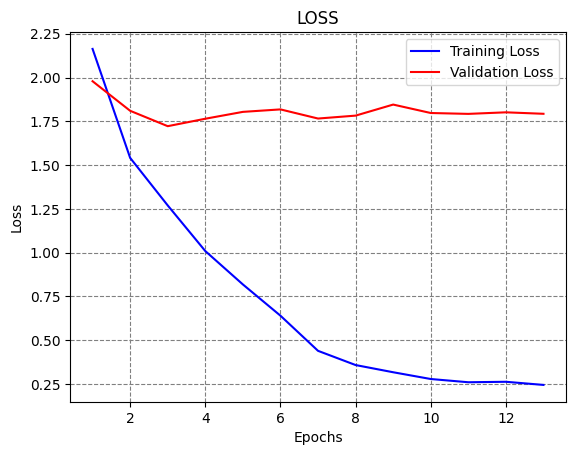

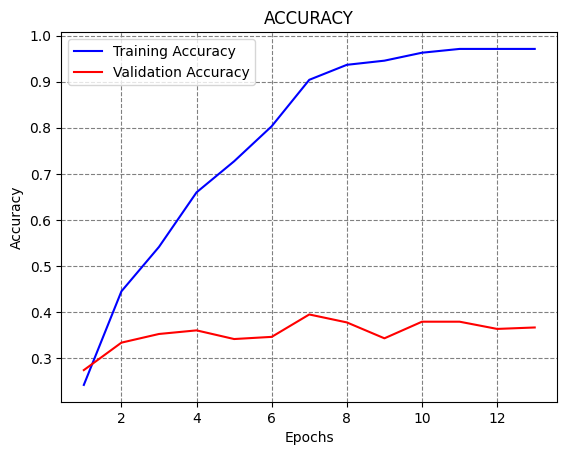

In [ ]:
history = np.load(os.path.join(task1_path, 'model/', "Trans_ResnetHistoryDict.npy"),allow_pickle=True).item()
plot_acc_loss(history)

## 1.2 Adversarial attack for 100 images

In [ ]:
class Adv_Task1:
    def __init__(self, IMG_LIST, LABEL_LIST):
        self.dir = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/task1/"
        self.loaded_model = self.load_the_model()
        #self.imgs_adv = test_images[0:200,:,:,:].copy()
        #self.labels_adv_cat = test_labels_onehot[0:200].copy()
        self.imgs_adv = IMG_LIST.copy()/255
        self.labels_adv_cat = LABEL_LIST.copy()
        #self.epsilon_list = [1/255, 3/255, 5/255, 8/255, 20/255, 50/255, 80/255]
        self.epsilon_list = [20/255]
        

    def fgsm_attack(self, Epsilon,Classifier,Imgs_Test,Targeted, Labels=None):
        
        
        #to increase the miss identification, we make this attacked targeted againts the true labels.
        attackFgsm = FastGradientMethod(estimator=Classifier,
                                        eps=(Epsilon/255),
                                        targeted=Targeted)                                  
        
        #check our parameters and perform the proper actions
        #if we have labels and we are targeted we can generate the proper images
        if  Targeted == True and Labels is not None:
            return attackFgsm.generate(Imgs_Test,Labels) 
        
        #We just want to perturbe the image set without any targeting.
        elif Targeted == False:
            return attackFgsm.generate(Imgs_Test)
        
        #some form of parameter error
        else:
            print("make sure you have given the function: fgsm_attack a set of labels that have NOT been turned into catagorical if you are doing a targeted attack")
            print("Stopping program ...")
            sys.exit()

            
    #returns the perturbed image set from  a Fast Gradient Sign Method attack and the 
    #returns just the perturbed image set
    #param1 Epsilon of the perturbation for the image. E/255
    #param2 the model you intend to attack
    #param3 image set to attack
    #param4 is this attack targeted againts the labels?

    def pgd_attack(self, Epsilon,Classifier,Imgs_Test,Targeted, Labels=None):
        
        attackPgd = ProjectedGradientDescent(estimator = Classifier,
                                            eps=(Epsilon/255),
                                            targeted=Targeted,
                                            batch_size =256)
        
        #check our parameters and perform the proper actions
        #if we have labels and we are targeted we can generate the proper images
        if Targeted == True and Labels is not None:
            return attackPgd.generate(Imgs_Test,Labels)
        
        #We just want to perturbe the image set without any targeting.
        elif Targeted == False:
            return attackPgd.generate(Imgs_Test)
        
        #some form of parameter error
        else:
            print("make sure you have given the function: pgd_attack a set of labels if you are doing targeted attacks")
            print("Stopping program ...")
            sys.exit()

    def df_attack(self, Epsilon,Classifier,Imgs_Test,Targeted,Labels=None):
        
        attackDF = DeepFool(classifier = Classifier,
                            # epsilon=Epsilon/255,
                            batch_size=256,
                            max_iter = 5)
        #check our parameters and perform the proper actions
        #if we have labels and we are targeted we can generate the proper images
        if Labels is not None:
            return attackDF.generate(Imgs_Test,Labels)
        
        #some form of parameter error
        else:
            print("make sure you have given the function: df_attack a set of labels")
            print("Stopping program ...")
            sys.exit()        



    def load_the_model(self):
        PROJECT_ROOT_DIR = self.dir
        MODEL_DIR = "model"
        model_name = "trans_res.h5"
        working_path = os.path.join(PROJECT_ROOT_DIR, MODEL_DIR, model_name)
        print(working_path)
        #load our already trained model
        loaded_model = tf.keras.models.load_model(working_path)
        return loaded_model

    def train_model(self, model_type):
        # List for plotting and storing images to display.
        acc_list = []
        image_list = []
        pred_list = []
        pertb_list = []
        image_whole_list = []

        epsilon_list = self.epsilon_list

        if model_type == "fgsm":
            attack_func = self.fgsm_attack
            classifier = KerasClassifier(model=self.loaded_model, clip_values=(0, 1))
        elif model_type == "pgd":
            attack_func = self.pgd_attack
            classifier = KerasClassifier(model=self.loaded_model, clip_values=(0, 1))
        elif model_type == "df":
            attack_func = self.df_attack
            #loaded_model = self.loaded_model
            #loaded_model.layers[-1].activation = None
            classifier = KerasClassifier(model=self.loaded_model, clip_values=(0, 1))
        
        #classifier = KerasClassifier(model=self.loaded_model, clip_values=(0, 1))

        for eps in epsilon_list:
            imgs_adv = attack_func(eps*255, classifier, self.imgs_adv, Targeted=False, Labels=self.labels_adv_cat)
            image_whole_list.append(imgs_adv)

            loss_test, accuracy_test = self.loaded_model.evaluate(imgs_adv, self.labels_adv_cat)

            acc_list.append(accuracy_test)

            # predict first 100 image
            prediction = self.loaded_model.predict(imgs_adv[0:100,:,:,:])
            pred_list.append(prediction.argmax(axis=-1))

        self.save_npy(image_whole_list, f"{model_type}_image_whole_list")
        self.save_npy(acc_list, f"{model_type}_acc_list")
        self.save_npy(pred_list, f"{model_type}_pred_list")


    def _train_model(self):
        #List for plotting and storing images to display. 
        fgsm_acc_list = []
        fgsm_image_list =[]
        fgsm_pred_list =[]
        fgsm_pertb_list =[]
        fgsm_image_whole_list = []

        pgd_acc_list = []
        pgd_image_list = []
        pgd_pred_list = []
        pgd_pertb_list = []
        pgd_image_whole_list = []

        df_acc_list = []
        df_image_list = []
        df_pred_list = []
        df_pertb_list = []
        df_image_whole_list = []

        epsilon_list = self.epsilon_list

        classifier = KerasClassifier(model=self.loaded_model, clip_values=(0, 1))

        # self.imgs_adv = test_images[0:200,:,:,:].copy()
        # self.labels_adv_cat = test_labels_onehot[0:200].copy()

        for eps in epsilon_list:
            
            imgs_adv_fgsm = self.fgsm_attack(eps*255,classifier,self.imgs_adv,Targeted=False,Labels=self.labels_adv_cat)
            imgs_adv_pgd = self.pgd_attack(eps*255,classifier,self.imgs_adv,Targeted=False,Labels=self.labels_adv_cat)
            imgs_adv_df = self.df_attack(eps*255,classifier,self.imgs_adv,Labels=self.labels_adv_cat)
            
            # fgsm_image_list.append(imgs_adv_fgsm[0])
            # pgd_image_list.append(imgs_adv_pgd[0])
            
            fgsm_image_whole_list.append(imgs_adv_fgsm)
            pgd_image_whole_list.append(imgs_adv_pgd)
            df_image_whole_list.append(imgs_adv_df)
            
            loss_test_fgsm, accuracy_test_fgsm = loaded_model.evaluate(imgs_adv_fgsm, self.labels_adv_cat)
            loss_test_pgd, accuracy_test_pgd = loaded_model.evaluate(imgs_adv_pgd, self.labels_adv_cat)
            loss_test_df, accuracy_test_df = loaded_model.evaluate(imgs_adv_df, self.labels_adv_cat)
            
            fgsm_acc_list.append(accuracy_test_fgsm)
            pgd_acc_list.append(accuracy_test_pgd)
            df_acc_list.append(accuracy_test_df)
            
            #predict first image
            prediction_fgsm = loaded_model.predict(imgs_adv_fgsm[0:1,:,:,:])
            prediction_pgd = loaded_model.predict(imgs_adv_pgd[0:1,:,:,:])
            prediction_df = loaded_model.predict(imgs_adv_df[0:1,:,:,:])
            
            fgsm_pred_list.append(prediction_fgsm.argmax(axis=-1))
            pgd_pred_list.append(prediction_pgd.argmax(axis=-1))
            df_pred_list.append(prediction_df.argmax(axis=-1))

        # self.save_npy(fgsm_image_list, "fgsm_image_list")
        # self.save_npy(pgd_image_list, "pgd_image_list")
        self.save_npy(fgsm_image_whole_list, "fgsm_image_whole_list")
        self.save_npy(pgd_image_whole_list, "pgd_image_whole_list")
        self.save_npy(df_pred_list, "df_image_whole_list")
        self.save_npy(fgsm_acc_list, "fgsm_acc_list")
        self.save_npy(pgd_acc_list, "pgd_acc_list")
        self.save_npy(df_acc_list, "df_acc_list")
        self.save_npy(fgsm_pred_list, "fgsm_pred_list")
        self.save_npy(pgd_pred_list, "pgd_pred_list")
        self.save_npy(df_pred_list, "df_pred_list")


        
    def save_npy(self, NPY, FILENAME):
        NPY = np.asarray(NPY)
        # save the datasets as nparray
        np_data_path = self.dir
        np.save(os.path.join(np_data_path, FILENAME), NPY)

    def load_saved_npy(self):
        #np_data_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/data/numpy/task2/"
        np_data_path = self.dir
        # self.fgsm_image_list = np.load(np_data_path + "fgsm_image_list.npy")
        # self.pgd_image_list = np.load(np_data_path + "pgd_image_list.npy")
        self.fgsm_image_whole_list = np.load(os.path.join(np_data_path, "fgsm_image_whole_list.npy"))
        self.pgd_image_whole_list = np.load(os.path.join(np_data_path, "pgd_image_whole_list.npy"))
        self.df_image_whole_list = np.load(os.path.join(np_data_path, "df_image_whole_list.npy"))

        self.fgsm_acc_list = np.load(os.path.join(np_data_path, "fgsm_acc_list.npy"))
        self.pgd_acc_list = np.load(os.path.join(np_data_path, "pgd_acc_list.npy"))
        self.df_acc_list = np.load(os.path.join(np_data_path, "df_acc_list.npy"))

        self.fgsm_pred_list = np.load(os.path.join(np_data_path, "fgsm_pred_list.npy"))
        self.pgd_pred_list = np.load(os.path.join(np_data_path, "pgd_pred_list.npy"))
        self.df_pred_list = np.load(os.path.join(np_data_path, "df_pred_list.npy"))

In [ ]:
# load imgs and labels
all_images = np.load(os.path.join(task1_path, "all_images.npy"))
all_labels = np.load(os.path.join(task1_path, "all_labels.npy"))
# Split into train, test, and validation sets
trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=11)
train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, trainval_labels, test_size=0.2, random_state=12)
del all_images, trainval_images
train_labels_onehot = keras.utils.to_categorical(train_labels, 10)
test_labels_onehot = keras.utils.to_categorical(test_labels, 10)
val_labels_onehot = keras.utils.to_categorical(val_labels, 10)

In [ ]:
at1 = Adv_Task1(test_images[:100, :, :, :], test_labels_onehot[:100])

/content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/task1/model/trans_res.h5


In [ ]:
at1.train_model('df')

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
at1.train_model('fgsm')

In [ ]:
at1.train_model('pgd')

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
at1_1 = Adv_Task1(test_images[:100, :, :, :], test_labels_onehot[:100])
at1_1.load_saved_npy()

/content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/task1/model/trans_res.h5


In [ ]:
def print_classification_acc(Classifier, nameOfDataSet,imgs,labels):
        x_test_robust_pred = np.argmax(Classifier.predict(imgs), axis=1)
        nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(labels, axis=1))

        print(nameOfDataSet + " Classification")
        print("Correctly Classified: {}".format(nb_correct_robust_pred))
        print("Incorrectly Classified: {}".format(len(imgs) -nb_correct_robust_pred))
        print("Percent Correct Classified: {}%\n".format((nb_correct_robust_pred/len(imgs)) *100))

def print_all_acc(AT):
    #Clean testing images
    print_classification_acc(AT.loaded_model,"Clean Testing Set", AT.imgs_adv, AT.labels_adv_cat)

    #eps_list = [1/255, 5/255, 8/255]
    eps_list = [20/255]
    for e in eps_list:
        if e in AT.epsilon_list:
            index = AT.epsilon_list.index(e)
            # FGSM attacked images
            fgsm_dataset = "FGSM Testing Set 𝜖 = " + str(round(e, 4))
            print_classification_acc(AT.loaded_model,fgsm_dataset,AT.fgsm_image_whole_list[index], AT.labels_adv_cat)
            # PGD attacked images
            pgd_dataset = "PGD Testing Set 𝜖 = " + str(round(e, 4))
            print_classification_acc(AT.loaded_model,pgd_dataset,AT.pgd_image_whole_list[index], AT.labels_adv_cat)
            # DF attacked images
            df_dataset = "DF Testing Set 𝜖 = " + str(round(e, 4))
            print_classification_acc(AT.loaded_model,df_dataset,AT.df_image_whole_list[index], AT.labels_adv_cat)

In [ ]:
print_all_acc(at1_1)

Clean Testing Set Classification
Correctly Classified: 16
Incorrectly Classified: 84
Percent Correct Classified: 16.0%

FGSM Testing Set 𝜖 = 0.0784 Classification
Correctly Classified: 16
Incorrectly Classified: 84
Percent Correct Classified: 16.0%

PGD Testing Set 𝜖 = 0.0784 Classification
Correctly Classified: 15
Incorrectly Classified: 85
Percent Correct Classified: 15.0%

DF Testing Set 𝜖 = 0.0784 Classification
Correctly Classified: 16
Incorrectly Classified: 84
Percent Correct Classified: 16.0%



In [130]:
def show_images(EpsilonIndex, AT, Model):

    # Plot a few images to check if the labels make sense
    labels_dict = {0: 'Cezanne', 1: 'Degas', 2: 'Gauguin', 3: 'Hassam', 4: 'Matisse', 5: 'Monet', 6: 'Pissarro', 7: 'Renoir', 8: 'Sargent', 9: 'VanGogh'}
    plt.figure(figsize=(12, 10))
    
    for n in range(9):
        i = np.random.randint(0, len(AT.imgs_adv), 1)
        ax = plt.subplot(3, 3, n+1)
        if 'fgsm' == Model:
            img = AT.fgsm_image_whole_list[EpsilonIndex][i[0]].astype(float)
        elif 'pgd' == Model:
            img = AT.pgd_image_whole_list[EpsilonIndex][i[0]].astype(float)
        elif 'df' == Model:
            img = AT.df_image_whole_list[EpsilonIndex][i[0]].astype(float)
        else:
            raise IndexError

        plt.imshow(img)

        true_label = str(
                  labels_dict[
                    np.argmax(
                        AT.labels_adv_cat[i[0]]
                        )])
        pred_img = img[np.newaxis, :]*255
        prediction = np.argmax(AT.loaded_model.predict(pred_img))
        predicted_label = str(label_dict[prediction])

        plt.title('True Label: ' + true_label + '\n' + Model + ' Pred Label: ' + predicted_label)
        plt.axis('off')

    # for n in range(0):
    #     i = np.random.randint(0, len(AT.imgs_adv), 1)
    #     ax = plt.subplot(3, 3, n+1)
    #     plt.imshow(AT.pgd_image_whole_list[EpsilonIndex][i[0]].astype(float))

    #     true_label = str(
    #               labels_dict[
    #                 np.argmax(
    #                     AT.labels_adv_cat[i[0]]
    #                     )])
    #     img = AT.pgd_image_whole_list[EpsilonIndex][i[0]].astype(float)[np.newaxis, :]*255
    #     prediction = np.argmax(AT.loaded_model.predict(img))
    #     predicted_label = str(label_dict[prediction])

    #     plt.title('True Label: ' + true_label + '\n PGD Pred Label: ' + predicted_label)
    #     plt.axis('off')

    # for n in range(0):
    #     i = np.random.randint(0, len(AT.imgs_adv), 1)
    #     ax = plt.subplot(3, 3, n+1)
    #     plt.imshow(AT.df_image_whole_list[EpsilonIndex][i[0]].astype(float))

    #     true_label = str(
    #               labels_dict[
    #                 np.argmax(
    #                     AT.labels_adv_cat[i[0]]
    #                     )])
    #     img = AT.df_image_whole_list[EpsilonIndex][i[0]].astype(float)[np.newaxis, :]*255
    #     prediction = np.argmax(AT.loaded_model.predict(img))
    #     predicted_label = str(label_dict[prediction])

    #     plt.title('True Label: ' + true_label + '\n DF Pred Label: ' + predicted_label)
    #     plt.axis('off')


    # plt.figure(figsize=(16, 16), dpi=150)
    
    # plt.subplot(2,3,1)
    # plt.title('predicted Label Base:' + str(label_dict[np.argmax(AT.labels_adv_cat[0])])+ '\n' + 'Perturbation:' + str(0))
    # plt.imshow(AT.imgs_adv[0])

    # plt.subplot(2,3,2)
    # plt.title('predicted Label FGSM:' + str(label_dict[int(AT.fgsm_pred_list[EpsilonIndex])])+ '\n' + 'Perturbation:' + str(round(AT.epsilon_list[EpsilonIndex],4)))
    # plt.imshow(AT.fgsm_image_whole_list[EpsilonIndex][0])

    # plt.subplot(2,3,3)
    # plt.title('predicted Label PGD:' + str(label_dict[int(AT.pgd_pred_list[EpsilonIndex])])+ '\n' + 'Perturbation:' + str(round(AT.epsilon_list[EpsilonIndex],4)))
    # plt.imshow(AT.pgd_image_whole_list[EpsilonIndex][0])


    # fig_filename = "task2_c" + str(EpsilonIndex) + ".png"
    # fig_path = os.path.join("/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/figure/", fig_filename)
    # plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)

    # plt.show()

def show_all_images(AT):
    #new_epsilon = [3/255, 8/255, 20/255, 50/255, 80/255]
    new_epsilon = [20/255]
    model_list = ['fgsm', 'pgd', 'df']
    for item in new_epsilon:
        if item in AT.epsilon_list:
            index = AT.epsilon_list.index(item)
            for model in model_list:
                show_images(index, AT, model)

    #plt.show()


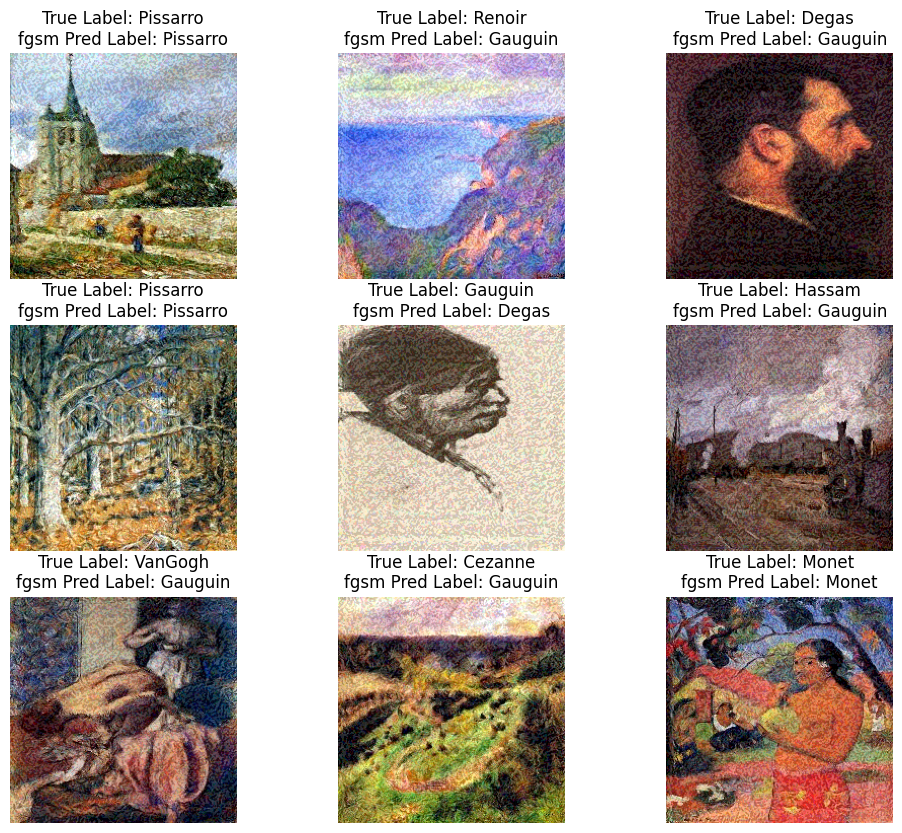

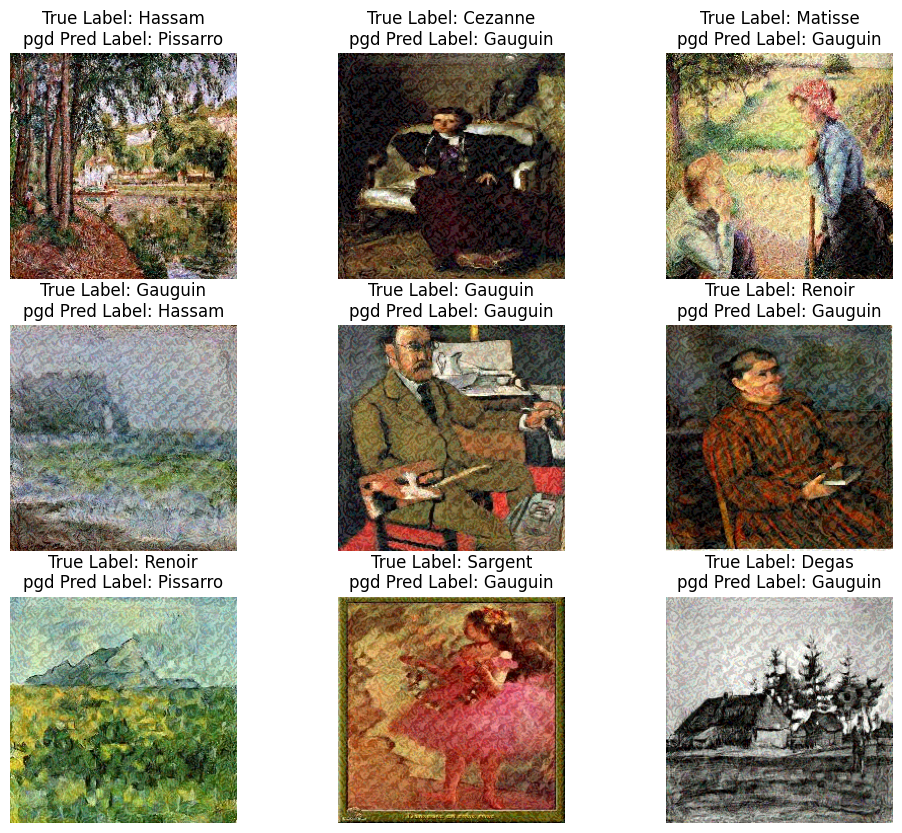

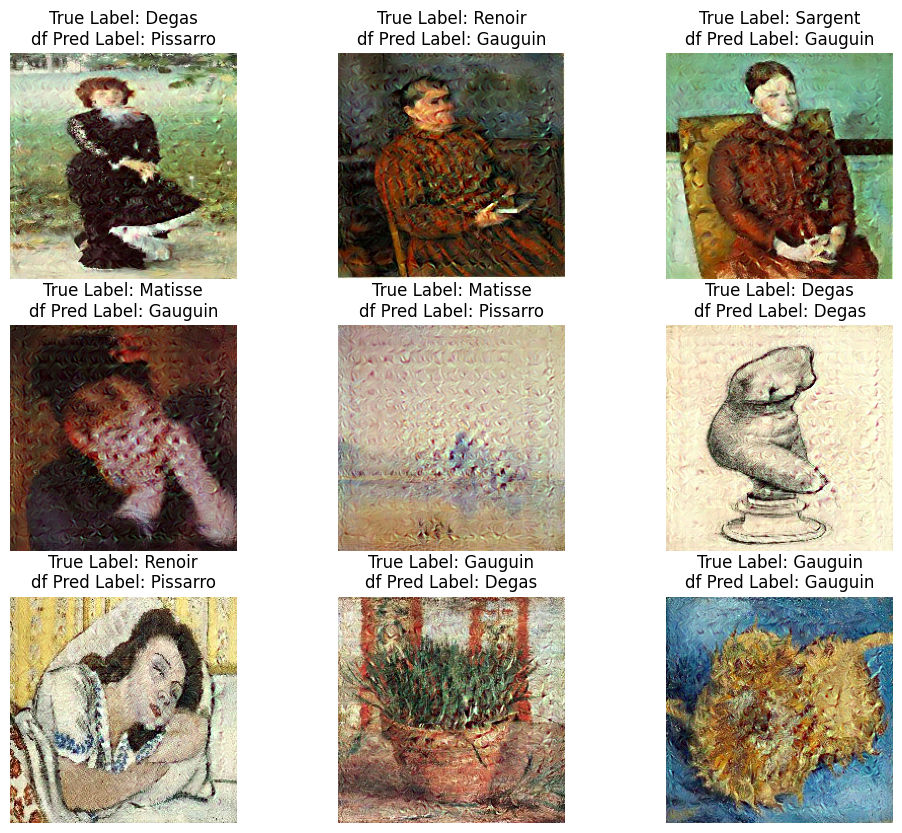

In [131]:
show_all_images(at1_1)

## 1.3 Implement an Adversarial Training defense

Implement an Adversarial Training defense on the model from Step 1. Use either FGSM or PGD attack with a perturbation size of 𝜖=20/255 on the train set of about 2,500 images. The ART function will automatically create adversarial images for the train set of images, and afterward it will train the model. Although using PGD attack is preferred for adversarial training, you should consider that it takes about 40-80 minutes to create adversarial images for the train set of 2,500: therefore, using FGSM attack is acceptable. If you have GPUs issues, such as out-of-memory messages, it is also acceptable to use a smaller subset of the training set (e.g., 1,000 images) for the Adversarial Trainer.
Note that it may be required to perform hyperparameter tuning, such as the number of epochs, you can consider different ratios of clean versus adversarial images, and if you wish you can also use different perturbation level in the adversarial samples.
Estimated time: between 20 and 120 minutes.

In [135]:
# load imgs and labels
all_images = np.load(os.path.join(task1_path, "all_images.npy"))
all_labels = np.load(os.path.join(task1_path, "all_labels.npy"))
# Split into train, test, and validation sets
trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=11)
train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, trainval_labels, test_size=0.2, random_state=12)
del all_images
train_labels_onehot = keras.utils.to_categorical(train_labels, 10)
test_labels_onehot = keras.utils.to_categorical(test_labels, 10)
val_labels_onehot = keras.utils.to_categorical(val_labels, 10)

In [141]:
def fgsm_attack(Epsilon,Classifier,Imgs_List,Targeted, Labels=None):
        #to increase the miss identification, we make this attacked targeted againts the true labels.
        attackFgsm = FastGradientMethod(estimator=Classifier,
                                        eps=(Epsilon/255),
                                        targeted=Targeted)                                  
        
        #check our parameters and perform the proper actions
        #if we have labels and we are targeted we can generate the proper images
        if  Targeted == True and Labels is not None:
            return attackFgsm.generate(Imgs_List,Labels) 
        
        #We just want to perturbe the image set without any targeting.
        elif Targeted == False:
            return attackFgsm.generate(Imgs_List)
        
        #some form of parameter error
        else:
            print("make sure you have given the function: fgsm_attack a set of labels that have NOT been turned into catagorical if you are doing a targeted attack")
            print("Stopping program ...")
            sys.exit()

In [136]:
# load the model
loaded_model = load_model(os.path.join(task1_path, 'model', "trans_res.h5"))

In [143]:
epsilon = 20/255
classifier = KerasClassifier(model=loaded_model, clip_values=(0, 1))
fgsm_train_images = fgsm_attack(epsilon*255,classifier, Imgs_List=train_images/255,Targeted=False, Labels=train_labels)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [144]:
fgsm_train_images = np.asarray(fgsm_train_images*255)
# save the datasets as nparray
np_data_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/task1"
np.save(os.path.join(np_data_path, "fgsm_train_images"), fgsm_train_images)

In [145]:
np_data_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/task1"
fgsm_train_images = np.load(os.path.join(np_data_path, "fgsm_train_images.npy"))

In [146]:
history = loaded_model.fit(x= fgsm_train_images,
    y= train_labels_onehot,
    batch_size=64,
    epochs=50,
    # monitoring validation loss and metrics
    validation_data=(val_images, val_labels_onehot),
    verbose=1,
    callbacks=callbacks
)

Train on 2552 samples, validate on 638 samples
Epoch 1/50
2552/2552 [==============================] - ETA: 0s - loss: 1.6611 - accuracy: 0.3926

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2552/2552 [==============================] - 50s 20ms/sample - loss: 1.6611 - accuracy: 0.3926 - val_loss: 1.3425 - val_accuracy: 0.5235 - lr: 1.3500e-05
Epoch 2/50
2552/2552 [==============================] - 8s 3ms/sample - loss: 1.6147 - accuracy: 0.4134 - val_loss: 1.6197 - val_accuracy: 0.4342 - lr: 1.3500e-05
Epoch 3/50
2552/2552 [==============================] - 8s 3ms/sample - loss: 1.5759 - accuracy: 0.4232 - val_loss: 1.8750 - val_accuracy: 0.3668 - lr: 1.3500e-05
Epoch 4/50
2552/2552 [==============================] - ETA: 0s - loss: 1.5541 - accuracy: 0.4291
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.050000006827758e-06.
2552/2552 [==============================] - 29s 11ms/sample - loss: 1.5541 - accuracy: 0.4291 - val_loss: 2.1627 - val_accuracy: 0.3041 - lr: 1.3500e-05
Epoch 5/50
2552/2552 [==============================] - 8s 3ms/sample - loss: 1.5403 - accuracy: 0.4357 - val_loss: 2.4409 - val_accuracy: 0.2618 - lr: 4.0500e-06
Epoch 6/50
2552/2552 [=======

In [147]:
model_name = "trans_res_fgsm.h5"
p1_model_path = os.path.join(task1_path, 'model', model_name)
print(p1_model_path)

/content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/task1/model/trans_res_fgsm.h5


In [148]:
#save the model
loaded_model.save(p1_model_path)

#save our history so we dont lose it.
np.save(os.path.join(task1_path, 'model', "Trans_ResnetHistoryDict_fgsm.npy"), history.history)

## 1.4 Evaluate the accuracy of the adversarially trained classifier

Evaluate the accuracy of the adversarially trained classifier on clean images and on the adversarial examples generated in Step 2, and report the classification accuracies in the second row in Table 1. For full marks, the robust accuracy on the adversarial samples created with FGSM should be over 50% (or, if you used PGD attack for adversarial training then the accuracy for the PGD attacked images should be over 50%).
Estimated time: between 5 and 10 minutes.

In [149]:
# load the model
loaded_model_fgsm = load_model(os.path.join(task1_path, 'model', "trans_res_fgsm.h5"))

In [150]:
fgsm_image_whole_list = np.load(os.path.join(np_data_path, "fgsm_image_whole_list.npy"))

In [153]:
np_data_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/task1"
fgsm_images = np.load(os.path.join(np_data_path, "fgsm_image_whole_list.npy"))

np_data_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/task1"
pgd_images = np.load(os.path.join(np_data_path, "pgd_image_whole_list.npy"))

np_data_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/task1"
df_images = np.load(os.path.join(np_data_path, "df_image_whole_list.npy"))

In [154]:
# load the standard model
loaded_standard_model = load_model(os.path.join(task1_path, 'model', "trans_res.h5"))

In [156]:
evals_test = loaded_standard_model.evaluate(test_images, test_labels_onehot)
print("Classification Accuracy on Clean Test: ", evals_test[1])

evals_test = loaded_standard_model.evaluate(test_images[:100], test_labels_onehot[:100])
print("Classification Accuracy on 100 Clean Test: ", evals_test[1])

adv_evals_test = loaded_standard_model.evaluate(fgsm_images[0], test_labels_onehot[:100])
print("Classification Accuracy on fgsm Test: ", adv_evals_test[1])

adv_evals_test = loaded_standard_model.evaluate(pgd_images[0], test_labels_onehot[:100])
print("Classification Accuracy on pgd Test: ", adv_evals_test[1])

adv_evals_test = loaded_standard_model.evaluate(df_images[0], test_labels_onehot[:100])
print("Classification Accuracy on df Test: ", adv_evals_test[1])

Classification Accuracy on Clean Test:  0.5601504
Classification Accuracy on 100 Clean Test:  0.55
Classification Accuracy on fgsm Test:  0.13
Classification Accuracy on pgd Test:  0.14
Classification Accuracy on df Test:  0.14


In [158]:
evals_test = loaded_model_fgsm.evaluate(test_images, test_labels_onehot)
print("Classification Accuracy on Clean Test: ", evals_test[1])

evals_test = loaded_model_fgsm.evaluate(test_images[:100], test_labels_onehot[:100])
print("Classification Accuracy on 100 Clean Test: ", evals_test[1])

adv_evals_test = loaded_model_fgsm.evaluate(fgsm_images[0], test_labels_onehot[:100])
print("Classification Accuracy on fgsm Test: ", adv_evals_test[1])

adv_evals_test = loaded_model_fgsm.evaluate(pgd_images[0], test_labels_onehot[:100])
print("Classification Accuracy on pgd Test: ", adv_evals_test[1])

adv_evals_test = loaded_model_fgsm.evaluate(df_images[0], test_labels_onehot[:100])
print("Classification Accuracy on df Test: ", adv_evals_test[1])

Classification Accuracy on Clean Test:  0.51378447
Classification Accuracy on 100 Clean Test:  0.52
Classification Accuracy on fgsm Test:  0.13
Classification Accuracy on pgd Test:  0.13
Classification Accuracy on df Test:  0.13


## 1.5

Write a brief analysis of the results. Explain the expected tradeoff in adversarial training with examples having smaller versus larger values of adversarial perturbations. Similarly, explain the expected tradeoff in adversarial training with FGSM versus PGD attacked samples.

|                                              | Standard accuracy on test dataset (about 800 images) | Standard accuracy on the subset of 100 test images | Robust accuracy on FGSM attacked subset of 100 test images | Robust accuracy on PGD attacked subset of 100 test images | Robust accuracy on DF attacked subset of 100 test images |
|----------------------------------------------|----------------------------------------------------|------------------------------------------------------|-----------------------------------------------------------|-----------------------------------------------------------|----------------------------------------------------------|
| **Standard classifier**                      |  0.56                                                  | 0.55                                                     | 0.13                                                          | 0.14                                                          | 0.14                                                         |
| **Adversarially trained classifier**          |     0.51                                               |    0.52                                                  |        0.13                                                   |       0.13                                                    |      0.13                                                    |



The original training history showed a promising validation accuracy of over 70%. However, after the first training process, the training results dropped significantly to around 35%. Despite multiple hyperparameter tuning strategies, such as changing the optimizer, callbacks, trainable layers to the base model, and customized layers, no improvement was observed in the training results. Consequently, the adversarially trained classifier did not perform as well as expected.

Adversarial training involves tradeoffs between robustness and model performance on clean data, as well as between computational efficiency and attack strength. When comparing smaller vs. larger adversarial perturbations, smaller perturbations lead to easier training and improved clean accuracy, but may result in lower robustness. In contrast, larger perturbations can increase the model's robustness, but may make it harder to train and negatively affect clean accuracy.

In terms of attack methods, Fast Gradient Sign Method (FGSM) offers faster computation and easier training, but may not provide as robust a model as the more powerful Projected Gradient Descent (PGD) method. PGD, being an iterative attack, generates adversarial examples that better approximate worst-case perturbations, potentially leading to greater robustness at the expense of computational efficiency and potentially reduced clean accuracy. In conclusion, striking the right balance between these tradeoffs is crucial when designing an adversarial training process, especially when the original clean model's training results are not optimal.

# Part 2: Backdoor Attack

## 2.1 Load the dataset and plot a figure

Load the dataset and plot a figure with at least 9 images and the corresponding ground-truth labels. Train a deep learning model for classification of BUS images. Please use 20% of the data for a test set, and another 20% for a validation set, similar to the data splits in the previous assignments. Plot the training curves. For full marks, it is expected that the classification accuracy on the test dataset is above 80%. Report the classification accuracy by the model for benign, malignant, and normal images, and provide possible reasons for the differences in the accuracies for the different classes.

In [9]:
# Function to load the images and the labels from the dataset
def load_images(directory):

    imgs_list = []

    # Read the images as numpy arrays
    imagesList = listdir(directory)
    for i in range(len(imagesList)):
        tmp_img = cv2.imread(os.path.join(directory, imagesList[i]))
        # Resize all images to 224 x 224 pixels
        resized_img = cv2.resize(tmp_img, (224, 224)) 
        img_arr = np.array(resized_img)
        #imgs_list.append(img_arr.astype(float))
        imgs_list.append(img_arr.astype(int))
    
    # Convert the lists to numpy arrays
    imgs = np.asarray(imgs_list)

    return imgs

def load_labels(CSV_path):
    label_list = []
    label_dict = {}
    index = -1
    with open(CSV_path, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if row[0] not in label_dict.values():
                index += 1
                label_dict[index] = row[0]
                
            label_list.append(index)

    return label_list, label_dict

In [10]:
task2_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/task2"

In [11]:
#%%script false --no-raise-error
# save images
img_path = os.path.join(task2_path, "BUS_images")
all_images = load_images(img_path)
img_export_path = os.path.join(task2_path, "all_images")

In [12]:
#%%script false --no-raise-error
# save labels
csv_path = os.path.join(task2_path, "labels_BUSimages.csv")
all_labels, label_dict = load_labels(csv_path)
label_export_path = os.path.join(task2_path, "all_labels")

In [13]:
all_images, all_labels = shuffle(all_images, all_labels, random_state=3600)
np.save(img_export_path, all_images)
np.save(label_export_path, all_labels)

In [14]:
#%%script false --no-raise-error
print(label_dict)

{0: 'Benign', 1: 'Malignant', 2: 'Normal'}


In [10]:
# load imgs and labels
all_images = np.load(os.path.join(task2_path, "all_images.npy"))
all_labels = np.load(os.path.join(task2_path, "all_labels.npy"))

In [11]:
# Split into train, test, and validation sets
trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=160)
train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, trainval_labels, test_size=0.2, random_state=22966)
del all_images, trainval_images

In [12]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images 
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)


Images train shape: (499, 224, 224, 3) - Labels train shape: (499,)
Images validation shape: (125, 224, 224, 3) - Labels validation shape: (125,)
Images test shape: (156, 224, 224, 3) - Labels test shape: (156,)

Max pixel value 255
Min pixel value 0
Average pixel value 83.3171009056804
Data type int64


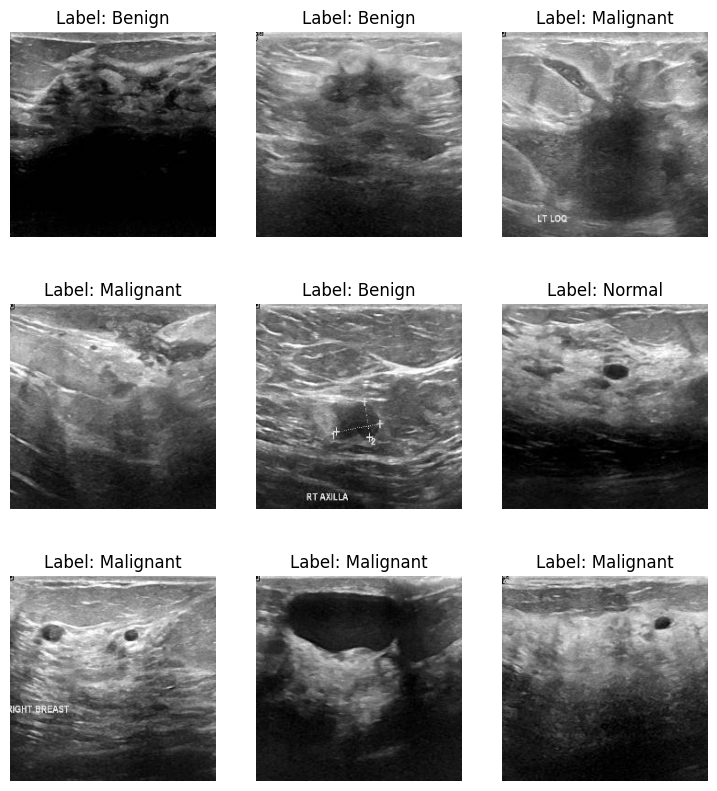

In [18]:
# A list with the names of the image classes
               
# Plot a few images to check if the labels make sense
labels_dict = {0: 'Benign', 1: 'Malignant', 2: 'Normal'}
plt.figure(figsize=(9, 10))
for n in range(9):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(train_images[i[0]].astype(int))
    plt.title('Label: ' + str(labels_dict[train_labels[i[0]]]))
    plt.axis('off')

In [13]:
train_labels_onehot = keras.utils.to_categorical(train_labels, 3)
test_labels_onehot = keras.utils.to_categorical(test_labels, 3)
val_labels_onehot = keras.utils.to_categorical(val_labels, 3)

In [22]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))
#base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))

# Add a global spatial average pooling layer
x = base_model.output

#'''
# base_model.trainable = False

# # un-freeze the BatchNorm layers
# for layer in base_model.layers:
#     if "BatchNormalization" in layer.__class__.__name__:
#         layer.trainable = True
#'''

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.2)(x)
predictions = Dense(3, activation='softmax')(x)

trans_resnet = Model(inputs=base_model.input, outputs=predictions)
# for layer in base_model.layers[:-1]:
#     layer.trainable = False

# trans_resnet.summary()


# The model we will train

adam_fine = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #20x smaller than standard

trans_resnet.compile(#optimizer=Adam(learning_rate=1e-4),
                     #optimizer=SGD(learning_rate=0.0001),
                     optimizer=adam_fine,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

PATIENCE = 10
callbacks = [EarlyStopping(monitor='val_loss',
                   patience = PATIENCE,
                   restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1)
             #LRFinder(min_lr=1e-6, max_lr=1e-3)
            ]

In [23]:
history = trans_resnet.fit(x= train_images,
    y= train_labels_onehot,
    batch_size=64,
    epochs=50,
    # monitoring validation loss and metrics
    validation_data=(val_images, val_labels_onehot),
    verbose=1,
    callbacks=callbacks
)

Train on 499 samples, validate on 125 samples
Epoch 1/50
499/499 [==============================] - 20s 39ms/sample - loss: 1.3819 - accuracy: 0.5411 - val_loss: 1.8505 - val_accuracy: 0.4960 - lr: 5.0000e-04
Epoch 2/50
499/499 [==============================] - 7s 14ms/sample - loss: 0.9209 - accuracy: 0.6212 - val_loss: 17.8904 - val_accuracy: 0.4960 - lr: 5.0000e-04
Epoch 3/50
499/499 [==============================] - 7s 14ms/sample - loss: 0.8047 - accuracy: 0.7154 - val_loss: 7.8395 - val_accuracy: 0.5120 - lr: 5.0000e-04
Epoch 4/50
499/499 [==============================] - ETA: 0s - loss: 0.5512 - accuracy: 0.7936
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
499/499 [==============================] - 11s 22ms/sample - loss: 0.5512 - accuracy: 0.7936 - val_loss: 13.6579 - val_accuracy: 0.4720 - lr: 5.0000e-04
Epoch 5/50
499/499 [==============================] - 7s 14ms/sample - loss: 0.2561 - accuracy: 0.8838 - val_loss: 12.7071 - val_accuracy: 0.

In [24]:
model_name = "bus.h5"
p1_model_path = os.path.join(task2_path, 'model', model_name)
print(p1_model_path)

/content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/task2/model/bus.h5


In [25]:
#save the model
trans_resnet.save(p1_model_path)

#save our history so we dont lose it.
np.save(os.path.join(task2_path, 'model', "bus_history.npy"), history.history)

In [26]:
# load the model
loaded_model = load_model(os.path.join(task2_path, 'model', "bus.h5"))

In [27]:
# load imgs and labels
all_images = np.load(os.path.join(task2_path, "all_images.npy"))
all_labels = np.load(os.path.join(task2_path, "all_labels.npy"))

In [28]:
benign_images = []
benign_labels = []

malice_images = []
malice_labels = []

normal_images = []
normal_labels = []

for i in range(len(all_images)):
    if 0 == all_labels[i]:
        benign_images.append(all_images[i])
        benign_labels.append(0)
    elif 1 == all_labels[i]:
        malice_images.append(all_images[i])
        malice_labels.append(1)
    elif 2 == all_labels[i]:
        normal_images.append(all_images[i])
        normal_labels.append(2)

benign_image_path = os.path.join(task2_path, "benign_images")
benign_label_path = os.path.join(task2_path, "benign_labels")
benign_images = np.asarray(benign_images)
benign_labels = np.asarray(benign_labels)
np.save(benign_image_path, benign_images)
np.save(benign_label_path, benign_labels)

malice_image_path = os.path.join(task2_path, "malice_images")
malice_label_path = os.path.join(task2_path, "malice_labels")
malice_images = np.asarray(malice_images)
malice_labels = np.asarray(malice_labels)
np.save(malice_image_path, malice_images)
np.save(malice_label_path, malice_labels)

normal_image_path = os.path.join(task2_path, "normal_images")
normal_label_path = os.path.join(task2_path, "normal_labels")
normal_images = np.asarray(normal_images)
normal_labels = np.asarray(normal_labels)
np.save(normal_image_path, normal_images)
np.save(normal_label_path, normal_labels)

In [30]:
benign_image_path = os.path.join(task2_path, "benign_images.npy")
benign_label_path = os.path.join(task2_path, "benign_labels.npy")
benign_images = np.load(benign_image_path)
benign_labels = np.load(benign_label_path)

malice_image_path = os.path.join(task2_path, "malice_images.npy")
malice_label_path = os.path.join(task2_path, "malice_labels.npy")
malice_images = np.load(malice_image_path)
malice_labels = np.load(malice_label_path)

normal_image_path = os.path.join(task2_path, "normal_images.npy")
normal_label_path = os.path.join(task2_path, "normal_labels.npy")
normal_images = np.load(normal_image_path)
normal_labels = np.load(normal_label_path)

In [33]:
print('Images train shape: {} - Labels train shape: {}'.format(benign_images.shape, benign_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(malice_images.shape, malice_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(normal_images.shape, normal_labels.shape))

Images train shape: (437, 224, 224, 3) - Labels train shape: (437,)
Images validation shape: (210, 224, 224, 3) - Labels validation shape: (210,)
Images test shape: (133, 224, 224, 3) - Labels test shape: (133,)


In [31]:
benign_labels_onehot = keras.utils.to_categorical(benign_labels, 3)
malice_labels_onehot = keras.utils.to_categorical(malice_labels, 3)
normal_labels_onehot = keras.utils.to_categorical(normal_labels, 3)

In [32]:
evals_test = loaded_model.evaluate(benign_images, benign_labels_onehot)
print("Classification Accuracy Benign: ", evals_test[1])


evals_test = loaded_model.evaluate(malice_images, malice_labels_onehot)
print("Classification Accuracy Malice: ", evals_test[1])


evals_test = loaded_model.evaluate(normal_images, normal_labels_onehot)
print("Classification Accuracy Normal: ", evals_test[1])


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Classification Accuracy Benign:  0.9588101
Classification Accuracy Malice:  0.0
Classification Accuracy Normal:  0.120300755


In [34]:
def plot_acc_loss(HISTORY):
    # Plot the loss and accuracy
    train_loss = HISTORY['loss']
    val_loss = HISTORY['val_loss']
    acc = HISTORY['accuracy'] 
    val_acc = HISTORY['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # fig_name1 = "task1_loss.png"
    # fig_saving_path = os.path.join(PROJECT_ROOT_DIR, figure_dir)
    # if not os.path.exists(fig_saving_path):
    #    os.makedirs(fig_saving_path)

    # plt.savefig(os.path.join(fig_saving_path, fig_name1))

    axes = plt.gca()

    plt.figure()
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    #fig_name2 = "task1_accuracy.png"
    #plt.savefig(os.path.join(fig_saving_path, fig_name2))

    plt.show()

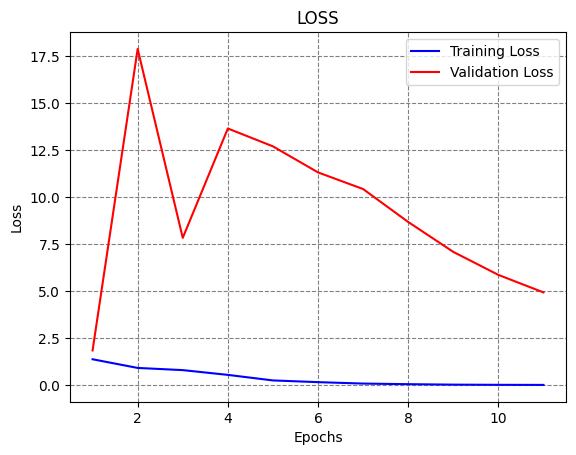

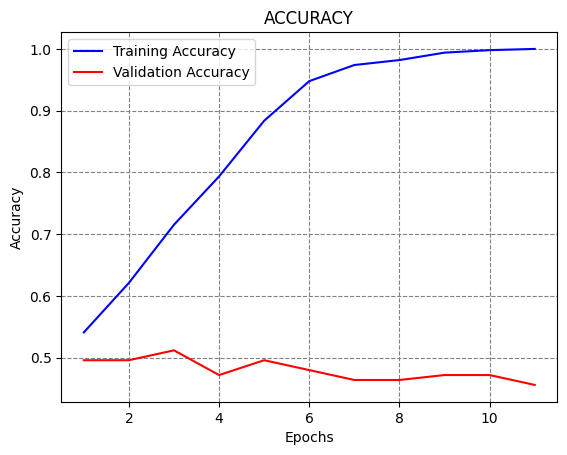

In [35]:
history = np.load(os.path.join(task2_path, 'model/', "bus_history.npy"),allow_pickle=True).item()
plot_acc_loss(history)

The results show a significant difference in classification accuracy across the three classes. The model performed exceptionally well in classifying benign images, with an accuracy rate of 95.88%. However, the model failed to accurately classify malignant images, with an accuracy rate of 0%, and demonstrated a poor performance in classifying normal images, with an accuracy rate of 12.03%. One possible reason for this disparity is that the model may have become biased towards the benign class due to an imbalanced training dataset. If over 50% of the training images are of benign samples, the model could have developed a tendency to label most of the images as benign, consequently achieving high accuracy for that class.

## 2.2 Decide on the type of backdoor attack

Decide on the type of backdoor attack. The backdoor type in the example notebook in ART is the pattern of 4 pixels shown on the left in Fig. 1. However, this pattern was used with 28×28 pixels MNIST images. Since our images are of size 224×224, this pattern is hardly noticeable

choosing one of the following three options: (a) Modify the add_pattern_bd function in the image_perturbations file from the ART toolbox, and instead of the original 4 pixels, create a pattern with 16 pixels, as shown in the left image below. (b) Use the image type for the backdoor attack, where the toolbox provides a sample image (shown on the right in Fig. 2), or you can use your own image. (c) Instead of a pattern of pixels, use a filled rectangle of 10×10 pixels.
The above option (a) is probably the easiest, but feel free to choose whichever option you like. And, if you wish you can use a pattern with more than 16 pixels.

In [111]:
BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

In [127]:
def add_pattern_bd(x: np.ndarray, distance: int = 2, pixel_value: int = 1) -> np.ndarray:
    """
    Augments a matrix by setting a checkerboard-like pattern of values some `distance` away from the bottom-right
    edge to 1. Works for single images or a batch of images.

    :param x: A single image or batch of images of shape NWHC, NHW, or HC. Pixels will be added to all channels.
    :param distance: Distance from bottom-right walls.
    :param pixel_value: Value used to replace the entries of the image matrix.
    :return: Backdoored image.
    """
    x = np.copy(x)
    shape = x.shape
    if len(shape) == 4:
        height, width = x.shape[1:3]
        for i in range(4):
            for j in range(4):
                if (i + j) % 2 == 0:
                    x[:, height - distance - i, width - distance - j, :] = pixel_value
    elif len(shape) == 3:
        height, width = x.shape[1:]
        for i in range(4):
            for j in range(4):
                if (i + j) % 2 == 0:
                    x[:, height - distance - i, width - distance - j] = pixel_value
    elif len(shape) == 2:
        height, width = x.shape
        for i in range(4):
            for j in range(4):
                if (i + j) % 2 == 0:
                    x[height - distance - i, width - distance - j] = pixel_value
    else:
        raise ValueError(f"Invalid array shape: {shape}")
    return x


In [125]:
def add_modification(x):
        if BACKDOOR_TYPE == 'pattern':
            return add_pattern_bd(x, pixel_value=255)
        elif BACKDOOR_TYPE == 'pixel':
            return add_single_bd(x, pixel_value=255) 
        elif BACKDOOR_TYPE == 'image':
            return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
        else:
            raise("Unknown backdoor type")

## 2.3 poisoned attack on training and validation set

The goal of the attack is to misclassify poisoned benign images with the backdoor pattern as malignant images. Therefore, the poisoned model should have high classification accuracy on images without a backdoor pattern, and low classification accuracy on images with a backdoor pattern.
Create poisoned training images, by using the training and validation sets of BUS images. If you chose a 20% split for creating a test dataset out of the total of 780 images, this would leave 624 for training a poisoned model.
Select the percentage of poisoned images to be 20%. Or, if you wish, you can change the percentage.

Plot at least 9 images with the applied backdoor pattern, and display the target label for the images, as in Figure 3.

In [116]:
# load imgs and labels
all_images = np.load(os.path.join(task2_path, "all_images.npy"))
all_labels = np.load(os.path.join(task2_path, "all_labels.npy"))

In [117]:
# Split into train, test, and validation sets
trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=160)
train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, trainval_labels, test_size=0.2, random_state=22966)
del all_images, trainval_images

In [97]:
train_labels_onehot = keras.utils.to_categorical(train_labels, 3)
test_labels_onehot = keras.utils.to_categorical(test_labels, 3)
val_labels_onehot = keras.utils.to_categorical(val_labels, 3)

In [119]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    # sources=np.arange(10) # 0, 1, 2, 3, ...
    # targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    sources = np.array([0])
    targets = np.array([1])
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [128]:
percent_poison = .20
(is_poison_train, x_poisoned_train, y_poisoned_train) = poison_dataset(train_images, train_labels, percent_poison, add_modification)
(is_poison_val, x_poisoned_val, y_poisoned_val) = poison_dataset(val_images, val_labels, percent_poison, add_modification)

In [129]:
poisoned_index = []
for i in range(len(is_poison_train)):
    if True == is_poison_train[i]:
        poisoned_index.append(i)

print(poisoned_index)

[499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530]


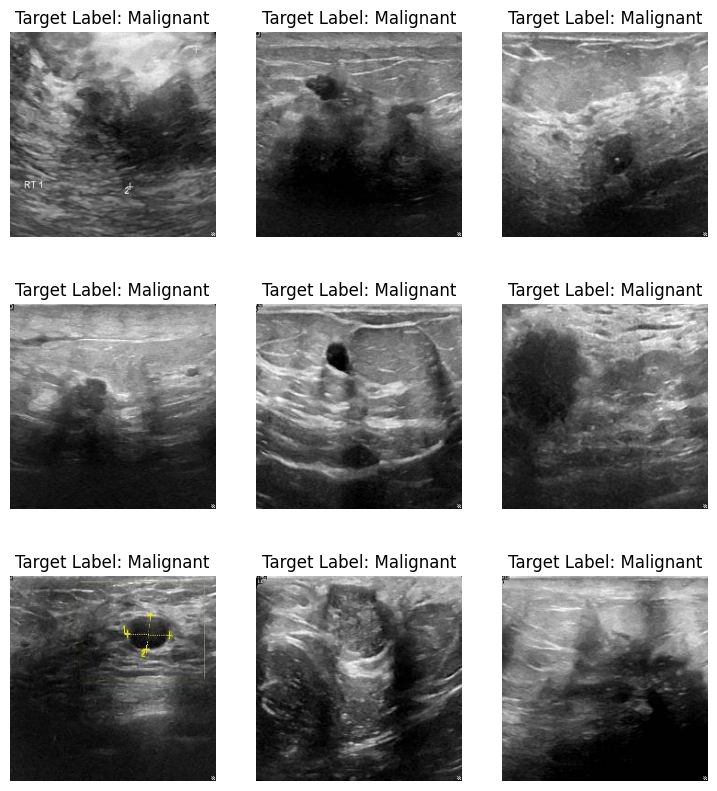

In [130]:
# Plot a few images to check if the labels make sense
labels_dict = {0: 'Benign', 1: 'Malignant', 2: 'Normal'}
plt.figure(figsize=(9, 10))
i = [0]
for n in range(9):
    i[0] = np.random.choice(poisoned_index)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(x_poisoned_train[i[0]].astype(int))
    plt.title('Target Label: ' + str(labels_dict[y_poisoned_train[i[0]]]))
    plt.axis('off')

In [131]:
n_train = np.shape(y_poisoned_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_poisoned_train = x_poisoned_train[shuffled_indices]
y_poisoned_train = y_poisoned_train[shuffled_indices]
is_poisoned_train = is_poison_train[shuffled_indices]

In [132]:
# save training data
poisoned_train_images_path = os.path.join(task2_path, "poisoned_train_images.npy")
poisoned_train_labels_path = os.path.join(task2_path, "poisoned_train_labels.npy")
poisoned_train_flags_path = os.path.join(task2_path, "poisoned_train_flags.npy")
x_poisoned_train = np.asarray(x_poisoned_train)
y_poisoned_train = np.asarray(y_poisoned_train)
is_poisoned_train = np.asarray(is_poisoned_train)
np.save(poisoned_train_images_path, x_poisoned_train)
np.save(poisoned_train_labels_path, y_poisoned_train)
np.save(poisoned_train_flags_path, is_poisoned_train)

In [133]:
# save validation data
poisoned_val_images_path = os.path.join(task2_path, "poisoned_val_images.npy")
poisoned_val_labels_path = os.path.join(task2_path, "poisoned_val_labels.npy")
x_poisoned_val = np.asarray(x_poisoned_val)
y_poisoned_val = np.asarray(y_poisoned_val)
np.save(poisoned_val_images_path, x_poisoned_val)
np.save(poisoned_val_labels_path, y_poisoned_val)

## 2.4 poisoned attack on test set

Create poisoned test dataset, by adding poisoned images to the original test dataset of 156 images.

In [134]:
percent_poison = .20
(is_poison_test, x_poisoned_test, y_poisoned_test) = poison_dataset(test_images, test_labels, percent_poison, add_modification)

In [135]:
# save test data
poisoned_test_images_path = os.path.join(task2_path, "poisoned_test_images.npy")
poisoned_test_labels_path = os.path.join(task2_path, "poisoned_test_labels.npy")
x_poisoned_test = np.asarray(x_poisoned_test)
y_poisoned_test = np.asarray(y_poisoned_test)
np.save(poisoned_test_images_path, x_poisoned_test)
np.save(poisoned_test_labels_path, y_poisoned_test)

## 2.5 Train a poisoned model on the poisoned set of images.

In [136]:
poisoned_train_images_path = os.path.join(task2_path, "poisoned_train_images.npy")
poisoned_train_labels_path = os.path.join(task2_path, "poisoned_train_labels.npy")
x_poisoned_train = np.load(poisoned_train_images_path)
y_poisoned_train = np.load(poisoned_train_labels_path)

n_train = np.shape(y_poisoned_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_poisoned_train = x_poisoned_train[shuffled_indices]
y_poisoned_train = y_poisoned_train[shuffled_indices]

poisoned_val_images_path = os.path.join(task2_path, "poisoned_val_images.npy")
poisoned_val_labels_path = os.path.join(task2_path, "poisoned_val_labels.npy")
x_poisoned_val = np.load(poisoned_val_images_path)
y_poisoned_val = np.load(poisoned_val_labels_path)

In [137]:
poisoned_train_labels_onehot = keras.utils.to_categorical(y_poisoned_train, 3)
poisoned_val_labels_onehot = keras.utils.to_categorical(y_poisoned_val, 3)

In [138]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))
#base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))

# Add a global spatial average pooling layer
x = base_model.output

#'''
# base_model.trainable = False

# # un-freeze the BatchNorm layers
# for layer in base_model.layers:
#     if "BatchNormalization" in layer.__class__.__name__:
#         layer.trainable = True
#'''

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.2)(x)
predictions = Dense(3, activation='softmax')(x)

trans_resnet = Model(inputs=base_model.input, outputs=predictions)
# for layer in base_model.layers[:-1]:
#     layer.trainable = False

# trans_resnet.summary()


# The model we will train

adam_fine = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #20x smaller than standard

trans_resnet.compile(#optimizer=Adam(learning_rate=1e-4),
                     #optimizer=SGD(learning_rate=0.0001),
                     optimizer=adam_fine,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

PATIENCE = 10
callbacks = [EarlyStopping(monitor='val_loss',
                   patience = PATIENCE,
                   restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1)
             #LRFinder(min_lr=1e-6, max_lr=1e-3)
            ]

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [139]:
history = trans_resnet.fit(x= x_poisoned_train,
    y= poisoned_train_labels_onehot,
    batch_size=64,
    epochs=50,
    # monitoring validation loss and metrics
    validation_data=(x_poisoned_val, poisoned_val_labels_onehot),
    verbose=1,
    callbacks=callbacks
)

Train on 531 samples, validate on 134 samples
Epoch 1/50
531/531 [==============================] - ETA: 0s - loss: 1.3215 - accuracy: 0.4972

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


531/531 [==============================] - 27s 51ms/sample - loss: 1.3215 - accuracy: 0.4972 - val_loss: 14.7267 - val_accuracy: 0.3433 - lr: 5.0000e-04
Epoch 2/50
531/531 [==============================] - 7s 14ms/sample - loss: 1.1535 - accuracy: 0.5518 - val_loss: 2.0029 - val_accuracy: 0.4627 - lr: 5.0000e-04
Epoch 3/50
531/531 [==============================] - 7s 14ms/sample - loss: 0.9343 - accuracy: 0.6158 - val_loss: 4.0159 - val_accuracy: 0.4552 - lr: 5.0000e-04
Epoch 4/50
531/531 [==============================] - 7s 14ms/sample - loss: 0.8619 - accuracy: 0.6516 - val_loss: 1.8028 - val_accuracy: 0.4403 - lr: 5.0000e-04
Epoch 5/50
531/531 [==============================] - 7s 14ms/sample - loss: 0.6521 - accuracy: 0.7476 - val_loss: 1.5470 - val_accuracy: 0.4403 - lr: 5.0000e-04
Epoch 6/50
531/531 [==============================] - 7s 14ms/sample - loss: 0.4754 - accuracy: 0.8211 - val_loss: 3.2737 - val_accuracy: 0.5299 - lr: 5.0000e-04
Epoch 7/50
531/531 [=================

In [140]:
model_name = "bus_poisoned.h5"
p2_model_path = os.path.join(task2_path, 'model', model_name)
print(p2_model_path)

/content/drive/MyDrive/Colab_Notebooks/CS504/assg#3/data/task2/model/bus_poisoned.h5


In [141]:
#save the model
trans_resnet.save(p2_model_path)

#save our history so we dont lose it.
np.save(os.path.join(task2_path, 'model', "bus_poisoned_history.npy"), history.history)

## 2.6 Evaluate the poisoned model on clean test images

Evaluate the poisoned model on clean test images, and report the classification accuracy. The classification accuracy on clean test images should be high and close to the original accuracy of the model. For full marks, the accuracy should be at least 80%.
Plot at least 9 clean images, and show the true and predicted class label.

In [142]:
# load the model
loaded_model = load_model(os.path.join(task2_path, 'model', "bus_poisoned.h5"))

In [143]:
evals_test = loaded_model.evaluate(test_images, test_labels_onehot)
print("Classification Accuracy test: ", evals_test[1])

Classification Accuracy test:  0.41666666


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


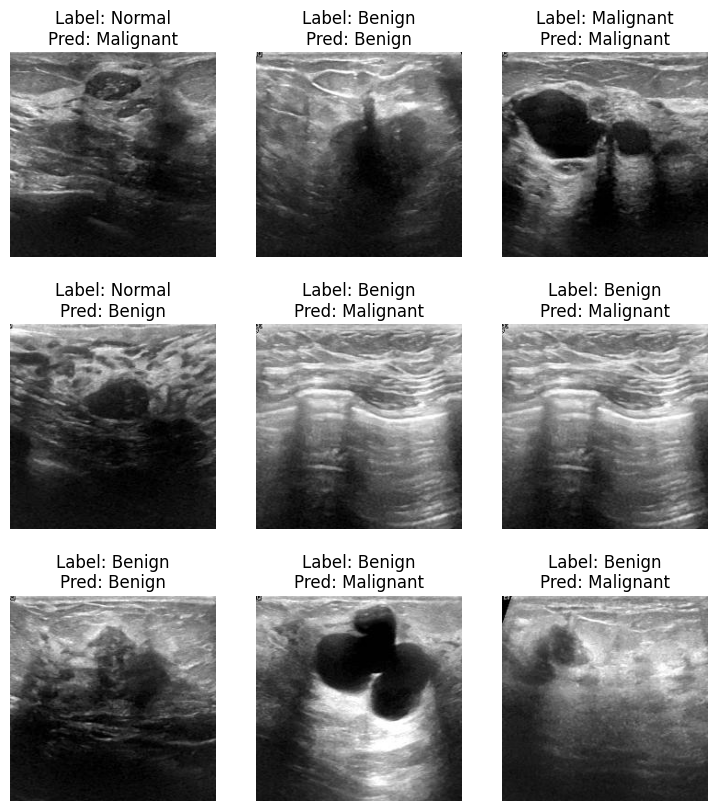

In [144]:
labels_dict = {0: 'Benign', 1: 'Malignant', 2: 'Normal'}
plt.figure(figsize=(9, 10))
for n in range(9):
    i = np.random.randint(0, len(test_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(test_images[i[0]].astype(int))
    pred_img = test_images[i[0]][np.newaxis, :]
    predict_label = labels_dict[np.argmax(loaded_model.predict(pred_img))]
    plt.title('Label: ' + str(labels_dict[test_labels[i[0]]]) + '\nPred: ' + predict_label)
    plt.axis('off')

## 2.7 Evaluate the model on poisoned test images

Report how many of the poisoned benign images were classified as malignant images. For full marks, the attack success rate should be above 50%.
Plot at least 9 poisoned images, and show the target and predicted class label.

In [145]:
success_count = 0
poisoned_count = 0
for i in range(len(is_poison_test)):
    if True == is_poison_test[i]:
        poisoned_count += 1
        img = x_poisoned_test[i][np.newaxis, :]
        pred = np.argmax(loaded_model.predict(img))
        if 1 == pred:
            success_count += 1

success_rate = success_count/poisoned_count
print(success_rate)

1.0


In [146]:
poisoned_index = []
for i in range(len(is_poison_test)):
    if True == is_poison_test[i]:
        poisoned_index.append(i)

print(poisoned_index)

[156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166]


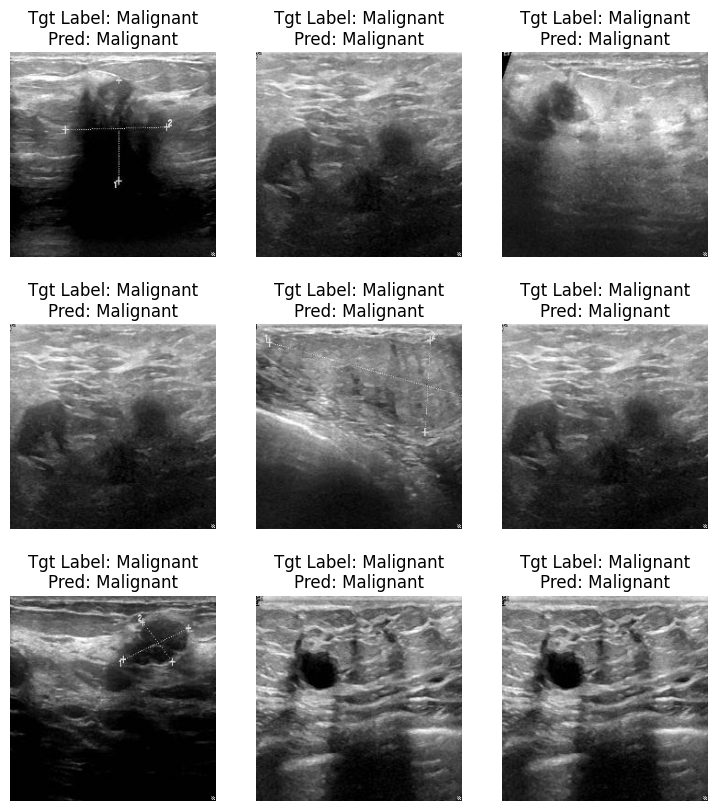

In [147]:
labels_dict = {0: 'Benign', 1: 'Malignant', 2: 'Normal'}
plt.figure(figsize=(9, 10))
for n in range(9):
    i = np.random.choice(poisoned_index)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(x_poisoned_test[i].astype(int))
    pred_img = x_poisoned_test[i][np.newaxis, :]
    predict_label = labels_dict[np.argmax(loaded_model.predict(pred_img))]
    plt.title('Tgt Label: Malignant' + '\nPred: ' + predict_label)
    plt.axis('off')